In [1]:
! git lfs install

! git clone https://github.com/timojl/clipseg 

! pip install diffusers -q

! pip install transformers -q -UU ftfy gradio  

! pip install git+https://github.com/openai/CLIP.git -q

Error: Failed to call git rev-parse --git-dir --show-toplevel: "fatal: not a git repository (or any of the parent directories): .git\n"
Git LFS initialized.
Cloning into 'clipseg'...
remote: Enumerating objects: 165, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 165 (delta 34), reused 41 (delta 16), pack-reused 91
Receiving objects: 100% (165/165), 1.21 MiB | 17.76 MiB/s, done.
Resolving deltas: 100% (75/75), done.
     |████████████████████████████████| 153 kB 9.3 MB/s 
     |████████████████████████████████| 120 kB 58.0 MB/s 
     |████████████████████████████████| 4.9 MB 7.5 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 5.3 MB 43.0 MB/s 
     |████████████████████████████████| 6.6 MB 41.4 MB/s 
     |████████████████████████████████| 270 kB 67.6 MB/s 
     |████████████████████████████████| 54 kB 3.4 MB/s 
     |████████████████████████████████| 84 kB 3.7 MB/s

In [2]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [3]:
%cd clipseg

/content/clipseg


In [4]:
! ls

datasets	     metrics.py        supplementary.pdf
environment.yml      models	       Tables.ipynb
evaluation_utils.py  overview.png      training.py
example_image.jpg    Quickstart.ipynb  Visual_Feature_Engineering.ipynb
experiments	     Readme.md	       weights
general_utils.py     score.py
LICENSE		     setup.py


In [5]:
import torch
import requests
import cv2 
from models.clipseg import CLIPDensePredT
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt

In [6]:
from io import BytesIO

from torch import autocast
import requests
import PIL
import torch
from diffusers import StableDiffusionInpaintPipeline as StableDiffusionInpaintPipeline

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [7]:
#! git lfs install

In [8]:
# load model
model = CLIPDensePredT(version='ViT-B/16', reduce_dim=64)
model.eval();


100%|████████████████████████████████████████| 335M/335M [00:01<00:00, 250MiB/s]


In [9]:
# non-strict, because we only stored decoder weights (not CLIP weights)
model.load_state_dict(torch.load('/content/clipseg/weights/rd64-uni.pth', map_location=torch.device('cuda')), strict=False);


In [10]:
device = "cuda"
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    revision="fp16", 
    torch_dtype=torch.float16,
    use_auth_token=True
).to(device)

Downloading:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/572 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/788 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/71.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

{'trained_betas'} was not found in config. Values will be initialized to default values.


In [11]:
# or load from URL...
image_url = 'https://okmagazine.ge/wp-content/uploads/2021/04/00-promo-rob-pattison-1024x1024.jpg' #'https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fimage.tmdb.org%2Ft%2Fp%2Foriginal%2F72xYNWRTVMDiKVa6SVu6EY0S9Np.jpg' #'https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png' 
input_image = Image.open(requests.get(image_url, stream=True).raw)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize((512, 512)),
])
img = transform(input_image).unsqueeze(0)

In [12]:
%cd ..

/content


In [13]:
input_image.convert("RGB").resize((512, 512)).save("init_image.png", "PNG")

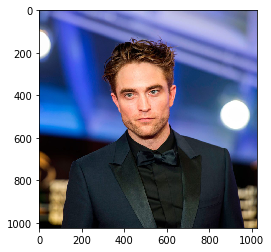

In [14]:
from matplotlib import pyplot as plt
plt.imshow(input_image, interpolation='nearest')
plt.show()

In [15]:
prompts = ['shirt']

In [16]:

# predict
with torch.no_grad():
    preds = model(img.repeat(len(prompts),1,1,1), prompts)[0]


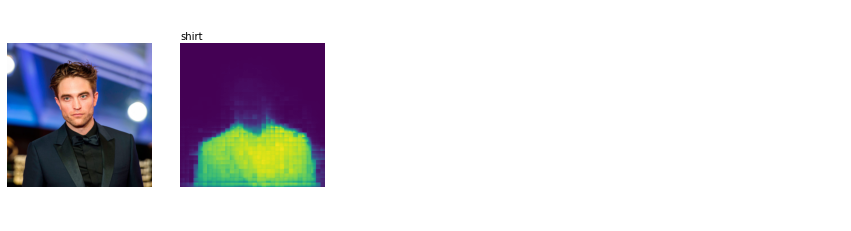

In [17]:
# visualize prediction
_, ax = plt.subplots(1, 5, figsize=(15, 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(input_image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompts[i]) for i in range(len(prompts))];

In [18]:
filename = f"mask.png"
plt.imsave(filename,torch.sigmoid(preds[0][0]))

In [19]:
img2 = cv2.imread(filename)

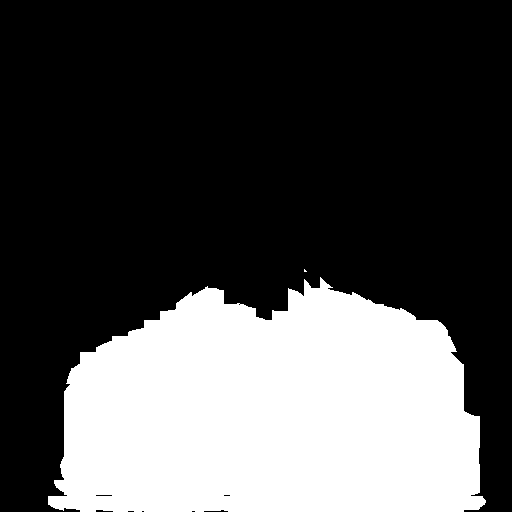

In [20]:
img2 = cv2.imread(filename)

gray_image = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

(thresh, bw_image) = cv2.threshold(gray_image, 100, 255, cv2.THRESH_BINARY)

# For debugging only:
cv2.imwrite(filename,bw_image)

# fix color format
cv2.cvtColor(bw_image, cv2.COLOR_BGR2RGB)

Image.fromarray(bw_image)

In [21]:
init_image = Image.open('init_image.png')
mask = Image.open('mask.png')

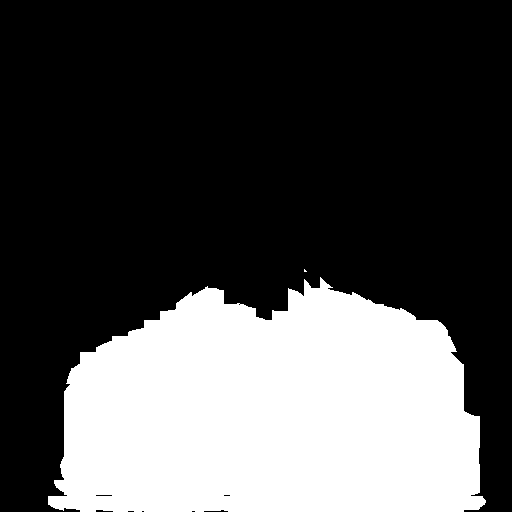

In [22]:
mask

In [23]:
with autocast("cuda"):
    images = pipe(prompt="a pink floral holiday casual shirt", init_image=init_image, mask_image=mask, strength=0.8)["sample"]


0it [00:00, ?it/s]

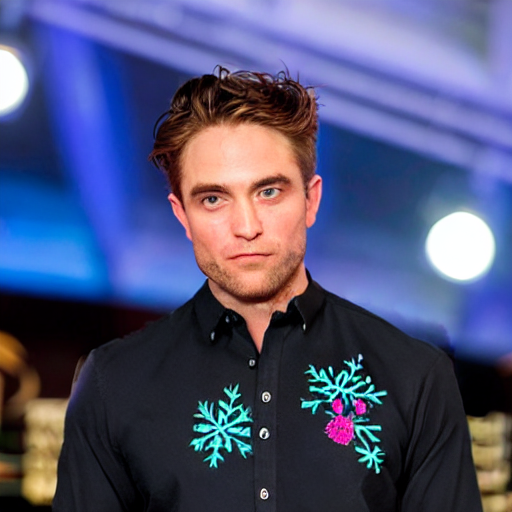

In [24]:
images[0]


# Web UI 

In [25]:
import gradio as gr

In [26]:
def prompt_paint(input_image, source_prompt, result_prompt):
  
  #input_image = Image.open(requests.get(image_url, stream=True).raw)

  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
      transforms.Resize((512, 512)),
  ])
  
  img = transform(input_image).unsqueeze(0)

  prompts = [source_prompt]

  # predict
  with torch.no_grad():
      preds = model(img.repeat(len(prompts),1,1,1), prompts)[0]


  input_image.convert('RGB').resize((512, 512)).save("init_image.png", "PNG")
  
  
  filename = f"mask.png"
  
  plt.imsave(filename,torch.sigmoid(preds[0][0]))

  img2 = cv2.imread(filename)

  gray_image = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

  (thresh, bw_image) = cv2.threshold(gray_image, 100, 255, cv2.THRESH_BINARY)

  # For debugging only:
  cv2.imwrite(filename,bw_image)

  # fix color format
  cv2.cvtColor(bw_image, cv2.COLOR_BGR2RGB)

  Image.fromarray(bw_image)

  init_image = Image.open('init_image.png')
  mask = Image.open('mask.png')

  with autocast("cuda"):
    images = pipe(prompt = result_prompt, init_image=init_image, mask_image=mask, strength=0.8)["sample"]

  return(images[0])


In [29]:
def prompt_paint_advanced(input_image, source_prompt, result_prompt, mask_precision, sd_strength):
  
  #input_image = Image.open(requests.get(image_url, stream=True).raw)

  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
      transforms.Resize((512, 512)),
  ])
  
  img = transform(input_image).unsqueeze(0)

  prompts = [source_prompt]

  # predict
  with torch.no_grad():
      preds = model(img.repeat(len(prompts),1,1,1), prompts)[0]


  input_image.convert('RGB').resize((512, 512)).save("init_image.png", "PNG")
  
  
  filename = f"mask.png"
  
  plt.imsave(filename,torch.sigmoid(preds[0][0]))

  img2 = cv2.imread(filename)

  gray_image = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

  (thresh, bw_image) = cv2.threshold(gray_image, mask_precision, 255, cv2.THRESH_BINARY)

  # For debugging only:
  cv2.imwrite(filename,bw_image)

  # fix color format
  cv2.cvtColor(bw_image, cv2.COLOR_BGR2RGB)

  Image.fromarray(bw_image)

  init_image = Image.open('init_image.png')
  mask = Image.open('mask.png')

  with autocast("cuda"):
    images = pipe(prompt = result_prompt, init_image=init_image, mask_image=mask, strength=sd_strength)["sample"]

  return(images[0])


In [30]:
with gr.Blocks() as demo:
    gr.Markdown("# Prompt Paint - Stable Diffusion")
    with gr.Tab("Prompt Paint - Basic"):
        with gr.Row():
            

            input_image = gr.Image(label = 'Upload your input image', type = 'pil')

            source_prompt = gr.Textbox(label="What is in the input image you want to change?")
            result_prompt = gr.Textbox(label="Replace it with?")

            image_output = gr.Image()
        
        image_button = gr.Button("Generate")

        image_button.click(prompt_paint, inputs=[input_image, source_prompt, result_prompt ], outputs=image_output)

    with gr.Tab("Prompt Paint - Advanced"):
        with gr.Row():
            

            input_image = gr.Image(label = 'Upload your input image', type = 'pil')

            source_prompt = gr.Textbox(label="What is in the input image you want to change?")
            result_prompt = gr.Textbox(label="Replace it with?")

                        
            mask_precision = gr.Slider(minimum = 50, maximum = 255, value = 70, label = 'Mask Precision')

            sd_strength = gr.Slider(minimum = 0, maximum = 1, value = 0.8, step = 0.1, label = 'Stable Diffusion Strength')
            

            image_output = gr.Image()
        
        image_button_advanced = gr.Button("Generate")

        image_button_advanced.click(prompt_paint_advanced, inputs=[input_image, source_prompt, result_prompt, mask_precision, sd_strength ], outputs=image_output)

demo.launch(debug = True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://21482.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


0it [00:00, ?it/s]

Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x7f3af2e60210>,
 'http://127.0.0.1:7860/',
 'https://21482.gradio.app')